In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib import colors, cm
from astropy.io import fits, ascii
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import default_cosmology
import glob
import matplotlib as mpl
import pandas as pd
from astropy.coordinates import SkyCoord

In [2]:
lcdm = default_cosmology.get()
!pwd

/Users/mila/Documents/Research/Postdoc/efeds-dwarfAGN


In [12]:
with open('grp_cat.reg') as f: 
    a = f.readlines()
# print(a) #so yes this is what we use to mask out groups

In [5]:
from astropy.table import vstack 
ptsrc = fits.open('ptsrc_cat.fits')[1].data
ptsrc_lowsig = fits.open('ptsrc_lowsig.fits')[1].data

In [6]:
allpts = pd.DataFrame()
allpts.insert(0, 'RA', np.hstack((ptsrc['RA'], ptsrc_lowsig['RA'])))
allpts.insert(1, 'DEC', np.hstack((ptsrc['DEC'], ptsrc_lowsig['DEC'])))

(0.0, 6000.0)

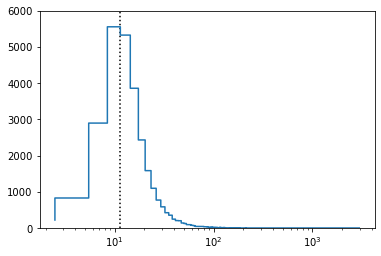

In [650]:
cts = ptsrc['APE_CTS_s'] + ptsrc['APE_CTS_t'] + ptsrc['APE_CTS_u']
hist, bins = np.histogram(cts, bins=1000, range=(1, cts.max()))
x = (bins[:-1]+bins[1:])/2.
plt.step(x, hist)
plt.xscale('log')
plt.vlines(x[np.argmax(hist)], 0, 6000, color='k', linestyle='dotted')
plt.ylim(0,6000)

In [3]:
gama = ascii.read('gama_ssfr.csv', delimiter=',')
gama.keys(), len(gama)

(['RA',
  'DEC',
  'Z',
  'sSFR_0_1Gyr_best_fit',
  'sSFR_0_1Gyr_percentile16',
  'sSFR_0_1Gyr_percentile50',
  'sSFR_0_1Gyr_percentile84',
  'mass_stellar_best_fit',
  'mass_stellar_percentile16',
  'mass_stellar_percentile50',
  'mass_stellar_percentile84'],
 1841)

# Galaxy Properties

0.06072248777838131


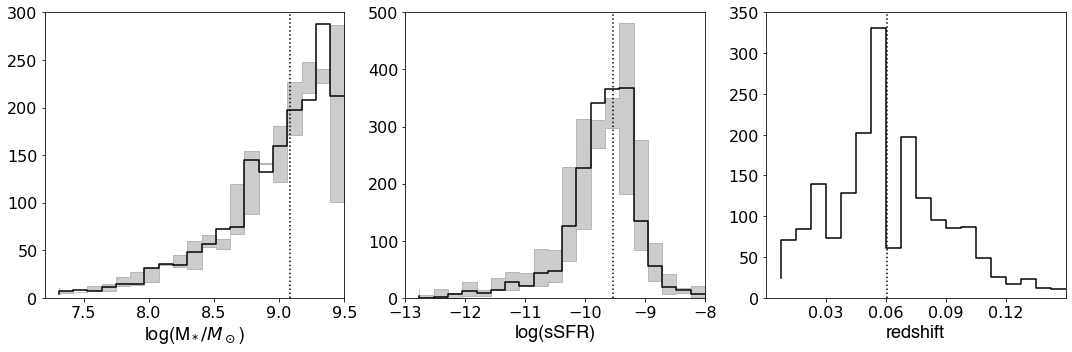

In [168]:
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
font = mpl.font_manager.FontProperties(family='helvetica', size=18)

fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax1, ax2, ax3 = ax.flatten()
hist, bins = np.histogram(gama['mass_stellar_percentile50'], bins=21, range=(7.2,9.5))
hist1, bins = np.histogram(gama['mass_stellar_percentile16'], bins=21, range=(7.2,9.5))
hist2, bins = np.histogram(gama['mass_stellar_percentile84'], bins=21, range=(7.2,9.5))
ax1.step(bins[1:], hist, color='k')
ax1.fill_between(bins[1:], hist1, hist2, color='k', alpha=0.2, step='pre')
ax1.vlines(x=np.median(np.log10(gama['mass_stellar_best_fit'])),ymin=0,ymax=485,color='k',linestyles='dotted')
ax1.set_ylim(0,300)
ax1.set_xlabel(r'log(M$_*/M_\odot$)', fontsize=16,font=font)
ax1.set_xlim(7.2,9.5)
# ax1.set_xticks([10.4, 10.6, 10.8, 11.0])

hist, bins = np.histogram(gama['sSFR_0_1Gyr_percentile50'], bins=21, range=(-13,-8))
hist1, bins = np.histogram(gama['sSFR_0_1Gyr_percentile16'], bins=21, range=(-13,-8))
hist2, bins = np.histogram(gama['sSFR_0_1Gyr_percentile84'], bins=21, range=(-13,-8))
ax2.step(bins[1:], hist, color='k')
ax2.fill_between(bins[1:], hist1, hist2, color='k', alpha=0.2, step='pre')
ax2.vlines(x=np.median(np.log10(gama['sSFR_0_1Gyr_best_fit'])),ymin=0,ymax=550,color='k',linestyles='dotted')
ax2.set_ylim(0,500)
ax2.set_xlabel(r'log(sSFR)', fontsize=16,font=font)
ax2.set_xlim(-13,-8)
# ax2.set_xticks([10.4, 10.6, 10.8, 11.0])

zmean = np.mean(gama['Z'])
ax3.vlines(x=zmean,ymin=0,ymax=650,color='k',linestyles='dotted')
hist, bins = np.histogram(gama['Z'], bins=20, range=(0,0.15))
ax3.step(bins[1:], hist, color='k')
ax3.set_xticks([0.03, 0.06, 0.09, 0.12])
ax3.set_xlim(0,0.15)
bins[np.argmax(hist)]
ax3.set_xlabel(r'redshift', fontsize=16, font=font)
ax3.set_ylim(0,350)

for a in ax.flatten(): ama = a.get_ylim()[1]; a.set_ylim(0,ama)
for a in [ax1,ax2, ax3]: a.set_ylabel('')


fig.tight_layout()
print(zmean)
plt.savefig('galaxy-props.png', dpi=156)

In [29]:
def radec_to_pix(ra, dec, head):
    
    ra0 = head['CRVAL1']  #  =  1.3386000000000E+02                                                  
    rap0 = head['CRPIX1'] #  =  1.1249500000000E+04                                                  
    dra = head['CDELT1']  #  = -1.1111111276679E-03                                                  
    dec0 = head['CRVAL2'] #  =  1.5000000000000E+00                                                  
    decp0 = head['CRPIX2']#  =  7.4995000000000E+03                                                  
    ddec = head['CDELT2'] #  =  1.1111111276679E-03  
    
    rapix = (ra - ra0)/dra + rap0
    decpix = (dec - dec0)/ddec + decp0
    
    return rapix, decpix

In [43]:
img = fits.getdata('../eFEDS-galaxies/img_0520_excl_grp_pts.fits')
head = fits.getheader('../eFEDS-galaxies/img_0520_excl_grp_pts.fits')
rapix, decpix = radec_to_pix(gama['RA'],gama['DEC'], head)

In [44]:
ratix = np.array([125,130,135,140,145])
dectix = np.array([-2,0,2,4,6])
xtix, ytix = radec_to_pix(ratix, dectix, head)

c = SkyCoord(ra=ratix*u.deg, dec=dectix*u.deg)

(3000.0, 12000.0)

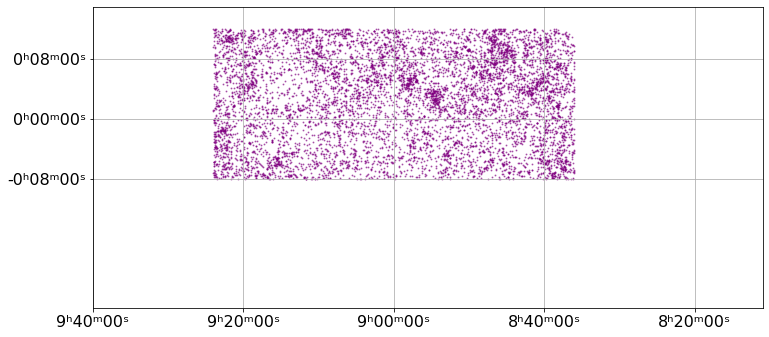

In [33]:
fig, ax = plt.subplots(figsize=(12,36))
plt.imshow(img,origin='lower',cmap=cm.afmhot_r, norm=colors.LogNorm(5.3e-2,53))
plt.scatter(rapix, decpix, color='purple', alpha=0.5, s=1)
plt.xticks(xtix, c.ra.to_string(unit=u.hourangle, fields=3, format='unicode'))
plt.yticks(ytix, c.dec.to_string(unit=u.hourangle, fields=3, format='unicode'))
plt.grid(True)
plt.ylim(3000,12000)

In [4]:
def crossmatch(cat1, cat2, tab=False, arr=False, ra1='RA', ra2='RA', dec1='DEC', dec2='DEC'):
	#cat1 contains the dmcopy or dmextract regions
	#cat2 is a table
	inds = []
	if tab:
		for i in range(len(cat1)):
			inds.append(np.argmin(abs(cat2[ra2] - cat1[ra1][i]) + abs(cat2[dec2] - cat1[dec1][i])))
	elif arr:
		for i in range(len(cat1)):
			inds.append(np.argmin(abs(cat2[ra2] - cat1[i,0]) + abs(cat2[dec2] - cat1[i,1])))
	else:
		print("invalid data type")
	return inds

In [160]:
inds = crossmatch(cat1=gama, cat2=allpts, ra1='RA', dec1='DEC', tab=True)
offset = (allpts.iloc[inds]['RA'] - gama['RA'])**2 + (allpts.iloc[inds]['DEC'] - gama['DEC'])**2

(0.0, 40.0)

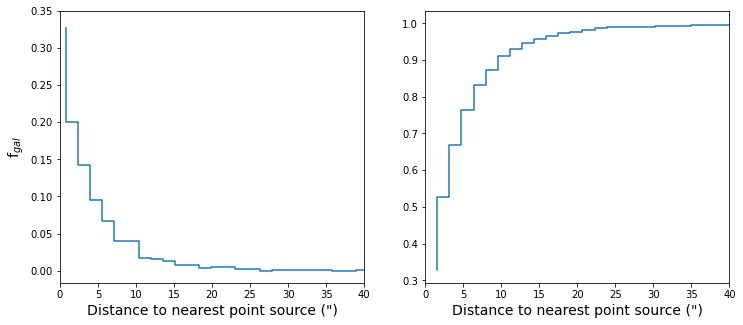

In [162]:
#the offset is in degrees
# offset *= 3600
from scipy import stats
hist, bins = np.histogram(offset, range=(offset.min(), offset.max()), bins=100)
hist2, left, w, _ = stats.cumfreq(offset, numbins=100, defaultreallimits=(offset.min(), offset.max()))
x = left + np.arange(1, len(hist2)+1)*w
fig, ax = plt.subplots(ncols=2, sharex=True, figsize=(12,5))
ax[0].step((bins[:-1] + bins[1:])/2., hist/sum(hist))
ax[1].step(x, hist2/hist2.max())
ax[0].set_yticks([0,.05,.1,.15,.2,.25,.3, .35])
for a in ax.flatten():
    a.set_xlabel('Distance to nearest point source (")', fontsize=14)
#     a.set_ylim(0,.35)
ax[0].set_ylabel(r'f$_{gal}$', fontsize=14)
plt.xlim(0,40)

In [163]:
len(offset[offset < 10.]), len(offset[offset < 5.]), len(offset[offset < 2.]), len(offset[offset < 1.]) 

(1637, 1272, 707, 424)

In [164]:
inds = np.argwhere((offset.values < 1))[:,0]#
pts_1_arcsec = gama[inds]
inds = np.argwhere((offset.values > 1)*(offset.values < 2))[:,0]#
pts_1_2_arcsec = gama[inds]
inds = np.argwhere((offset.values > 2)*(offset.values < 5))[:,0]#
pts_2_5_arcsec = gama[inds]
inds = np.argwhere((offset.values > 5)*(offset.values < 10))[:,0]#
pts_5_10_arcsec = gama[inds]
inds = np.argwhere((offset.values > 10))[:,0]#
pts_10_arcsec = gama[inds]

In [175]:
reg = []
for gal in pts_1_arcsec:
    c = SkyCoord(ra = gal['RA'], dec = gal['DEC'], unit = (u.degree))
    c = c.to_string('hmsdms').replace('h',':').replace('m',':').replace('d',':').replace('s ',',').replace('s','')
    reg.append("box("+c+",2',2')")

with open('gal_with_pts_within_1arcsec.reg', 'w') as f:
    f.writelines(reg)

In [176]:
reg = []
for gal in pts_1_2_arcsec:
    c = SkyCoord(ra = gal['RA'], dec = gal['DEC'], unit = (u.degree))
    c = c.to_string('hmsdms').replace('h',':').replace('m',':').replace('d',':').replace('s ',',').replace('s','')
    reg.append("box("+c+",2',2')")

with open('gal_with_pts_1_2_arcsec.reg', 'w') as f:
    f.writelines(reg)

In [177]:
reg = []
for gal in pts_2_5_arcsec:
    c = SkyCoord(ra = gal['RA'], dec = gal['DEC'], unit = (u.degree))
    c = c.to_string('hmsdms').replace('h',':').replace('m',':').replace('d',':').replace('s ',',').replace('s','')
    reg.append("box("+c+",2',2')")

with open('gal_with_pts_2_5_arcsec.reg', 'w') as f:
    f.writelines(reg)

In [178]:
reg = []
for gal in pts_5_10_arcsec:
    c = SkyCoord(ra = gal['RA'], dec = gal['DEC'], unit = (u.degree))
    c = c.to_string('hmsdms').replace('h',':').replace('m',':').replace('d',':').replace('s ',',').replace('s','')
    reg.append("box("+c+",2',2')")

with open('gal_with_pts_5_10_arcsec.reg', 'w') as f:
    f.writelines(reg)

In [179]:
reg = []
for gal in pts_10_arcsec:
    c = SkyCoord(ra = gal['RA'], dec = gal['DEC'], unit = (u.degree))
    c = c.to_string('hmsdms').replace('h',':').replace('m',':').replace('d',':').replace('s ',',').replace('s','')
    reg.append("box("+c+",2',2')")

with open('gal_with_pts_outside_10arcsec.reg', 'w') as f:
    f.writelines(reg)

In [ ]:
def image_crossmatch(files, master, name='gal_props.csv'):
    radec = np.zeros((len(files),2))
    for i in range(len(files)):
        h = fits.getheader(files[i])
        for line in h['HISTORY']:
            if ('CONT' in line) and ('x(' in line):
                c = SkyCoord(line.split('(')[1].split(',')[0]+' '+line.split(',')[1], unit=(u.hourangle, u.deg))
                radec[i] = (c.ra.to('deg').value, c.dec.to('deg').value)
    sub = pd.DataFrame()
    sub.insert(0, 'ind', [file.split('_')[-1].split('.')[0] for file in files])
    sub.insert(1, 'ra', radec[:,0])
    sub.insert(2, 'dec', radec[:,1])
    inds = crossmatch(sub, master, tab=True)
    sub.insert(3,'mass_stellar_best_fit', master.iloc[inds]['mass_stellar_best_fit'].values)
    sub.insert(4,'sSFR_best_fit', master.iloc[inds]['sSFR_0_1Gyr_best_fit'].values)
    sub.insert(5,'z', master.iloc[inds]['Z'].values)
    sub.to_csv(name, index=False)    

# Stacked images

In [7]:
from scipy import ndimage
def stacked_image(files, lenx, leny, inputtype='file'):
	img = np.zeros((lenx, leny))
	i = 0
	for file in files:
		if inputtype == 'file':
			f = fits.getdata(file)
		else:
			f = file
		x, y = f.shape
		# print(x,y)
		if y:
			starty = int((leny - y)/2)
			endy = starty+y
			startx = int((lenx - x)/2)
			endx = startx+x
			img[startx:endx,starty:endy] += f
	return ndimage.gaussian_filter(img, sigma=1, order=0)

In [113]:
def axisticks(ax, tfile, xmin, xmax, x=True, y=True, tickmax=400, ntix=5, fontsize=14, fac=1):
	xtix = np.linspace(-tickmax, tickmax, ntix)
	dx = fits.getheader(tfile)['CDELT1']*fac
	xpos = xtix/dx + (xmin+xmax)/2.
	if x:
		ax.set_xticks(xpos)
		ax.set_xticklabels(['%d' % x for x in xtix], fontsize=fontsize)
	if y:
		ax.set_yticks(xpos)
		ax.set_yticklabels(['%d' % x for x in xtix], fontsize=fontsize)

In [8]:
def save_stacks():
    gals = pd.read_csv('gal_props.csv', header=0)
    ms = gals['mass_stellar_best_fit']
    files = glob.glob('cut*fits'); files.sort()
    files78 = ['cut_0520_%d.fits' % ind for ind in gals[(ms > 10**7) * (ms < 10**8)]['ind'].values]
    files89 = ['cut_0520_%d.fits' % ind for ind in gals[(ms > 10**8) * (ms < 10**9)]['ind'].values]
    files9plus = ['cut_0520_%d.fits' % ind for ind in gals[(ms > 10**9)]['ind'].values]
    f = fits.getdata('cut_0520_0.fits')
    x, y = f.shape
    imall = stacked_image(files, x, y)
    im78 = stacked_image(files78, x, y)
    im89 = stacked_image(files89, x, y)
    im9plus = stacked_image(files9plus, x, y)
    np.save('img-all.npy', imall)
    np.save('img-78.npy', im78)
    np.save('img-89.npy', im89)
    np.save('img-9plus.npy', im9plus)

In [60]:
def annulus(array, rmin, rmax):
    x = np.arange(array.shape[0])
    y = np.arange(array.shape[1])
    x = x - x.mean()
    y = y - y.mean()
    X, Y = np.meshgrid(x,y)
    r2 = X**2 + Y**2 
#     print(rmin**2, rmax**2, r2)
    return np.argwhere((r2 > (rmin**2))*(r2 < (rmax**2)))

In [140]:
def plot_all(rmin=12.5, rmax=18.5, ret=True, save=False, fzmax=3,zlim=None):
    dirs = ['pts_1_2arcsec/', 'pts_2_5arcsec/', 'pts_5_10arcsec/', 'pts_outside_10arcsec/'] #'pts_within_1arcsec/',
    dirs = dirs[::-1]
    files = ['img-78.npy','img-89.npy','img-9plus.npy'] #'img-all.npy',
    fig, ax = plt.subplots(nrows = len(dirs), ncols=len(files), sharex=True, sharey=True, figsize=(16,12))
    if not zlim:
        zlim = np.zeros((len(files)))
    fig.subplots_adjust(bottom=0, top=1, left=0, right=0.8)
    # add an axes, lower left corner in [0.83, 0.1] measured in figure coordinate with axes width 0.02 and height 0.8

#     cb_ax = [fig.add_axes([0.05, 0.05, 0.3, 0.02]),fig.add_axes([0.36, 0.05, 0.3, 0.02]),
#              fig.add_axes([0.67, 0.05, 0.3, 0.02])]
    cb_ax = fig.add_axes([0.80, 0, 0.02, 1])
    for i in range(len(dirs)):
        for j in range(len(files)):
            im = np.load(dirs[len(dirs)-i-1]+files[j])
            bck_inds = annulus(im, rmin, rmax)
            bck = np.nanmedian(im[bck_inds])
            sb = (im-bck)/len(im)
            if not i and not zlim:
                zlim[j] = fzmax*sb.max()
            img = ax[i][j].imshow(sb, origin='lower', cmap=cm.RdBu_r, norm=colors.Normalize(-zlim[j], zlim[j]))
            if not (i+j):
                plt.colorbar(img, cax=cb_ax, aspect=10)
            if not j:
                ax[i][j].set_ylabel(dirs[len(dirs)-i-1])
#     plt.tight_layout(w_pad=-2, h_pad=-.1)
    if save:
        plt.savefig('rawstacks.png')
    if ret:
        return fig, ax

In [ ]:
gama[]

<ipython-input-171-131bf8b9166c>:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0,0,.9,1], w_pad=-10, h_pad=1)


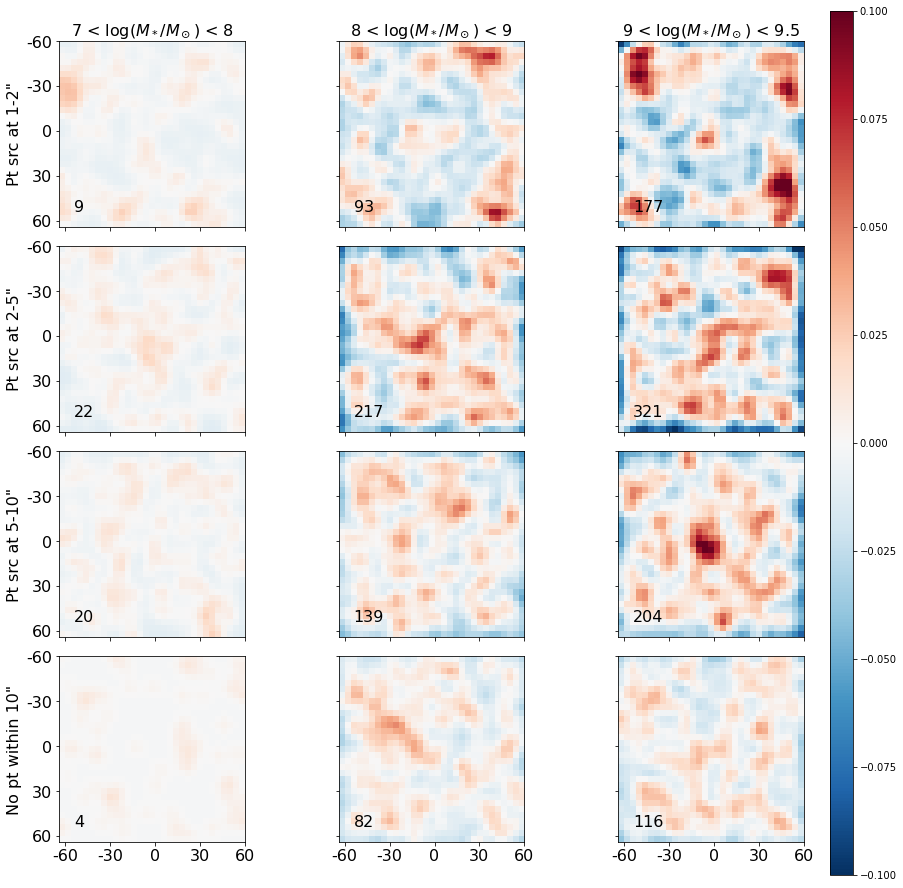

In [171]:
fig, ax = plot_all(rmax=18.75,fzmax=1, zlim=[.1,.1,.1,.1])
for i in range(4):
    axisticks(ax[i][0], 'pts_1_2arcsec/cut_0520_0.fits', 0, 31, x=False, tickmax=60, fac=3600, fontsize=16)
for i in range(3):
    axisticks(ax[3][i], 'pts_1_2arcsec/cut_0520_0.fits', 0, 31, y=False, tickmax=60, fac=-3600, fontsize=16)
ax[0][0].set_ylabel('Pt src at 1-2"', fontsize=16)
ax[1][0].set_ylabel('Pt src at 2-5"', fontsize=16)
ax[2][0].set_ylabel('Pt src at 5-10"', fontsize=16)
ax[3][0].set_ylabel('No pt within 10"', fontsize=16)
ax[0][0].set_title('7 < $\log(M_*/M_\odot)$ < 8', fontsize=16)
ax[0][1].set_title('8 < $\log(M_*/M_\odot)$ < 9', fontsize=16)
ax[0][2].set_title('9 < $\log(M_*/M_\odot)$ < 9.5', fontsize=16)
fig.tight_layout(rect=[0,0,.9,1], w_pad=-10, h_pad=1)

arrs = [pts_1_2_arcsec, pts_2_5_arcsec, pts_5_10_arcsec, pts_10_arcsec]
labs = ['1-2', '2-5', '5-10', '10+']
for i in range(len(arrs)):
    arr = arrs[i]
    ms = np.log10(arr['mass_stellar_best_fit'])
    ngals = [len(arr[(ms > 7)*(ms < 8)]), len(arr[(ms > 8)*(ms < 9)]), len(arr[(ms>9)])]
    for j in range(3):
        ax[i][j].text(2,2,str(ngals[j]), fontsize=16)

In [170]:
18.75*4

75.0

# Hardness Ratios

In [937]:
def cts_area_ratio(tab, prof=False, bck='bck-area'):
	if prof:
		cts = (tab['cts-0-5.5']+tab['cts-5.5-10']).sum()
		if bck == 'bck-area':
			bck_cts = tab['bck-cts'].sum()
			area = tab['bck-area']/(tab['area-0-5.5']+tab['area-5.5-10'])
		else:
			bck_cts = tab['150-250-cts'].sum()
			area = tab['150-250-area']/(tab['area-0-5.5']+tab['area-5.5-10'])
	else:
		cts = tab['cts'].sum()
		if bck == 'bck-area':
			bck_cts = tab['bck-cts'].sum()
			area = tab['bck-area']/(tab['area'])
		else:
			bck_cts = tab['150-250-cts'].sum()
			area = tab['150-250-area']/(tab['area'])
	return cts, bck_cts, np.nanmean(area[area<np.inf])

def hardness_ratio(hard,soft, prof=False):
	softsrc, softbck, softarea = cts_area_ratio(soft, prof=prof)
	allsrc, allbck, allarea = cts_area_ratio(hard, prof=prof) 
	print(int(softsrc), int(softbck), softarea, int(allsrc-softsrc), int(allbck-softbck), allarea)
	return int(softsrc), int(softbck), softarea, int(allsrc-softsrc), int(allbck-softbck), allarea

src0520 = pd.read_csv('../src_bck_cts.csv')
src0510 = pd.read_csv('../src_bck_cts_0510.csv')
print('low mass, 10-100: '); hardness_ratio(src0520[src0520['logMass'] < 10.7], src0510[src0510['logMass'] < 10.7], prof=False)
print('high mass, 10-100: ');hardness_ratio(src0520[src0520['logMass'] > 10.7], src0510[src0510['logMass'] > 10.7], prof=False)
# print('low mass, 0-10: ');hardness_ratio(prof0520[prof0520['logMass'] < 10.7], prof0510[prof0520['logMass'] < 10.7], prof=True)
# print('high mass, 0-10: ');hardness_ratio(prof0520[prof0520['logMass'] > 10.7], prof0510[prof0520['logMass'] > 10.7], prof=True)

low mass, 10-100: 
20802 23019 1.2142878669646995 9120 10326 1.2142878669646995
high mass, 10-100: 
16203 17380 1.1538900382047819 7370 7661 1.1538900382047819


(16203, 17380, 1.1538900382047819, 7370, 7661, 1.1538900382047819)

# Mass-Luminosity Relation

In [7]:
from scipy.optimize import curve_fit
from scipy.integrate import quad

path='../' #/data/gnarming/uchadaya/eFEDS/ if on hea comp
cdf = np.mean(np.mean(fits.getdata(path+'psf1.fits'), axis=1), axis=1)
eef = np.arange(0.4, 1.0, 0.05)
sb = eef/(np.pi*cdf**2)
area = np.pi * (cdf[1:]**2 - cdf[:-1]**2)
dE = eef[1:] - eef[:-1]
sb[1:] = dE / area
sb /= sb[0]
xcdf = (cdf[1:] + cdf[:-1])/2
xcdf = np.insert(xcdf,0,cdf[0]/2)
xcdf *= (4 * 1.45)

# print(xcdf, eef, sb)
def psf_curve(r, A, rs, beta):
	return A * (1 + (r/rs)**2)**(-beta) #Moffat function, beta=2.0 fitted for XMM

def psf_area(r, A, rs, beta): 
	#integrating this from r1 to r2 should give me the fraction of photons enclosed between those radii
		#IF THE PSF IS PROPERLY NORMALISED
		#in other words, integrating this gives the factor that the raw PSF should be normalised by. 
	return 2*np.pi*r * psf_curve(r, A, rs, beta) #

fit, _ =  curve_fit(psf_curve, xcdf, sb)
area_psf, _ = quad(psf_area, args=(fit[0],fit[1], fit[2]), a=0, b=np.infty) 
xp = np.arange(0,100,.1)
yp = psf_curve(xp, *fit)/area_psf

# def Lxrb(sdss, alpha = 9.05e28, beta = 1.62e39, low=False, high=False):  #alpha in erg/s/Msun, beta in erg/s/Msun/yr)
# 	# Lehmer et al. 2010
# 	dalpha = 0.37e28
# 	dbeta = 0.22e39
# 	if low:
# 		alpha -= dalpha
# 		beta -= dbeta
# 	if high:
# 		alpha += dalpha 
# 		beta += dbeta
# 	mstar = 10**sdss['logMass']
# 	sfr = 10**(sdss['ssfr'] - 9) * mstar #the -9 converts from Msun/Gyr to Msun/yr
# 	return alpha*mstar + beta*sfr

def Lxrb(sdss, alpha = 6.713e+28, beta = 2.552e+39, low=False, high=False):  #alpha in erg/s/Msun, beta in erg/s/Msun/yr)
	# Lehmer et al. 2019
    #their values are for 0.5-8keV. I use PIMMS to convert this to 0.5-2.0 keV, for ACIS, APEC using photon index = 1.7
    #ok now note. **This beta is too high.** In all the analyses use Mineo instead, 1.62e39. 
	if low:
		alpha = 5.983672482257647e+28, 
		beta = 1.8922033816407476e+39
	if high:
		alpha = 7.888016571050706e+28
		beta = 3.605519214113673e+39
	mstar = 10**sdss['logMass']
	sfr = 10**(sdss['ssfr'] - 9) * mstar #the -9 converts from Msun/Gyr to Msun/yr
	return alpha*mstar + beta*sfr


In [23]:
def sort(sdss):
    q = np.argsort(sdss['ssfr'])[:int(len(sdss)/3.)]
    sf = np.argsort(sdss['ssfr'])[int(2*len(sdss)/3.):]
    try: 
        return sf.values, q.values
    except AttributeError:
        return sf, q

So see, the integral does indeed yield the total luminosity between a and b

In [13]:
def scatter(Lx, err, Mleft, Mright, ax, color, label, nsigma=1, alpha=1, lw=2):
    x = (Mleft+Mright)/2.
    xerr = (Mright-Mleft)/2.
    valid = (Lx > 0)*(err < 1)
    ax.errorbar(x[valid], Lx[valid], xerr=xerr[valid], yerr=(Lx*err)[valid], color=color, alpha=alpha, linewidth=0, elinewidth=lw)
    ax.scatter(x[valid], Lx[valid], s=50, color=color, alpha=alpha, label=label)
    ax.scatter(x[~valid], Lx[~valid]*(1+nsigma*err[~valid]), color=color, marker='v', alpha=alpha)

In [14]:
def Lx_Mstar(Mleft, Mright, ax, gals=gals, alpha = 9.05e28, beta = 1.62e39, xrb=True, debug=False,mincts=-1e5,nsigma=1, bck='all',obs=True):
    Lx_r  = np.zeros(len(Mleft))
    err_r = np.zeros(len(Mleft))
    Lx_b  = np.zeros(len(Mleft))
    err_b = np.zeros(len(Mleft))

    for i in range(len(Mright)):
#         print(Mleft[i])
        tng = Lx_tng[(mtng > Mleft[i])*(mtng < Mright[i])]
        eag = Lx_eag[(meag > Mleft[i])*(meag < Mright[i])]
        if obs:
            subgals = gals[(gals['logMass'] > Mleft[i])*(gals['logMass'] < Mright[i])]
            top, bottom = sort(subgals)
        #trying a sum over profile

            Lx_b[i], err_b[i] = sb_prof(subgals.iloc[top], xrb=xrb,beta=beta,alpha=alpha, tot=True,mincts=mincts, bck=bck)
            Lx_r[i], err_r[i] = sb_prof(subgals.iloc[bottom], xrb=xrb,beta=beta,alpha=alpha, tot=True, mincts=mincts, bck=bck)

#         Lx_b[i], err_b[i] = Lx_stack(subgals[top],    xrb=True,alpha=alpha, beta=beta)
#         print('Q: ')
#         Lx_r[i], err_r[i] = Lx_stack(subgals[bottom], xrb=True,alpha=alpha, beta=beta)
#         print(err_b, err_r)
        ssfrtng = tng0510[(mtng > Mleft[i])*(mtng < Mright[i])][:,5]
        ssfreag = eagle0510[(meag > Mleft[i])*(meag < Mright[i])][:,5]

        redtng = np.argsort(ssfrtng)[:int(len(tng)/3.)]
        bluetng = np.argsort(ssfrtng)[int(2*len(tng)/3.):]
        redeag = np.argsort(ssfreag)[:int(len(eag)/3.)]
        blueeag = np.argsort(ssfreag)[int(2*len(eag)/3.):]

        ax.scatter((10**Mleft[i]+10**Mright[i])/2., np.nanmean(tng[bluetng]), color='None',edgecolors='tab:blue', marker='X', s=200, alpha=0.75, hatch='///')
        ax.scatter((10**Mleft[i]+10**Mright[i])/2., np.nanmean(eag[blueeag]), color='None',edgecolors='tab:blue', marker='H', s=200, alpha=0.75, hatch='///')
        ax.scatter((10**Mleft[i]+10**Mright[i])/2., np.nanmean(tng[redtng]), color='None',edgecolors='tab:red', marker='X', s=200, alpha=0.75, hatch='///')
        ax.scatter((10**Mleft[i]+10**Mright[i])/2., np.nanmean(eag[redeag]), color='None',edgecolors='tab:red', marker='H', s=200, alpha=0.75, hatch='///')
#         if debug:
#             print('Sim/obs: ', np.nanmean(tng[bluetng])/Lx_b[i],np.nanmean(eag[blueeag])/Lx_b[i],np.nanmean(tng[redtng])/Lx_r[i],np.nanmean(eag[redeag])/Lx_r[i])
#             print('SF/Q TNG, EAG: ', np.nanmean(tng[bluetng])/np.nanmean(tng[redtng]),np.nanmean(eag[blueeag])/np.nanmean(eag[redeag]))

    if debug and obs:
        print('SF: ', Lx_b, err_b, 'Q: ', Lx_r, err_r)
    if obs:
        scatter(Lx_b, err_b, 10**Mleft, 10**Mright, ax=ax, color='tab:blue', nsigma=nsigma, alpha=1, lw=2, label='SF')
        scatter(Lx_r, err_r, 10**Mleft, 10**Mright, ax=ax, color='tab:red', nsigma=nsigma, alpha=1, lw=2, label='Q')

    ax.scatter(1, 1, color='None',edgecolors='k', marker='X', s=200, alpha=0.5, label='TNG', hatch='///')
    ax.scatter(1, 1, color='None',edgecolors='k', marker='H', s=200, alpha=0.5, label='Eagle', hatch='///')
    ax.set_xlim(10**10.1, 10**11.3)

    h, l = ax.get_legend_handles_labels()
    ax.legend(h[-4:],l[-4:], fontsize=12)
    ax.set_yticks([1e38,1e40,1e42])
    ax.set_yticklabels([r'10$^{38}$',r'10$^{40}$',r'10$^{42}$'],fontsize=18, fontfamily='STIXGeneral')
    ax.set_xticklabels(['',r'10$^{10}$',r'10$^{11}$','',''],fontsize=18, fontfamily='STIXGeneral')
    ax.set_xlabel(r'M$_*$ (M$_\odot$)', fontfamily='STIXGeneral', fontsize=18)
    ax.set_ylabel(r'L$_x$ (0.5-2.0 keV) (erg/s)', fontfamily='STIXGeneral', fontsize=18)
    ax.figure.tight_layout()
    ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_xlabel(r'M$_*$ (M$_\odot$)', fontfamily='STIXGeneral', fontsize=18)
    ax.set_ylim(4e38,2.5e41)

In [25]:
def sb_bkg(tab, bck='bck-'):
    cts_to_erg = 1.624e-12
    dl2 = 4*np.pi*lcdm.angular_diameter_distance(tab['z']).to('cm')**2
    if bck == 'bck-':
        return np.nanmedian(tab['bck-cts']/(tab['bck-area']*tab['bck-exp'])) *dl2.mean() * cts_to_erg
    else:
        return np.nanmedian(tab['150-250-cts']/(tab['150-250-area']*tab['150-250-exp'])) *dl2.mean() * cts_to_erg

In [35]:
def plot(sb_err, ax, color, nsigma=1, alpha=1, lw=2, bkg=0,marker='v'):
    x = (sb_err[:,0] + sb_err[:,1])/2.
    xerr = (sb_err[:,0] - sb_err[:,1])/2.
    sb = sb_err[:,2]
    err = sb_err[:,3]
    valid = (sb > 0)*(err < 1)
    confident = (sb > bkg)
    iffy = (sb < bkg)
    ax.errorbar(x[valid*confident], sb[valid*confident], xerr=xerr[valid*confident], yerr=(sb*err)[valid*confident], color=color, alpha=alpha, linewidth=0, elinewidth=lw)
    ax.scatter(x[valid*confident], sb[valid*confident], s=50, color=color, alpha=alpha)
    ax.errorbar(x[valid*iffy], sb[valid*iffy], xerr=xerr[valid*iffy], yerr=(sb*err)[valid*iffy], color=color, alpha=alpha/2., linewidth=0, elinewidth=lw)
    ax.scatter(x[valid*iffy], sb[valid*iffy], s=50, color=color, alpha=alpha/2.)
    ax.scatter(x[~valid], sb[~valid], color=color, marker=marker, alpha=alpha, s=50)
    ax.vlines(x[~valid], sb[~valid], sb[~valid]*(1+nsigma*err[~valid]), color=color, alpha=alpha)
    ax.errorbar(x[~valid], sb[~valid], xerr=xerr[~valid], yerr=None, color=color, alpha=alpha, linewidth=0, elinewidth=lw)


## Surface Brightness Profiles

In [29]:
def xrb_psf(sdss, alpha = 9.05e28, beta = 1.62e39, fit=fit, area_psf=area_psf):
		norm = Lxrb(sdss,alpha=alpha,beta=beta).mean()
		xp = np.arange(0,100,.1)
		yp = psf_curve(xp, *fit)/area_psf
		return xp, yp,norm


In [33]:
def format_plot(ax, yconv=3.1e39,y=True):
	ax.set_xlabel('R (kpc)', fontsize=14)
	ax.set_xlim(5.5,100)
	ax.set_xscale('log')
	ax.set_yscale('log')
	ax.set_ylim(3e33, 4e37)
	if y:
		ax.set_ylabel(r'$\Sigma_X$ (erg/s/kpc$^2$)',fontsize=14)
	for y in ax.get_yticklabels(): 
		y.set_fontfamily('STIXGeneral')
		y.set_fontsize(14)
	for x in ax.get_xticklabels(): 
		x.set_fontfamily('STIXGeneral')
		x.set_fontsize(14)
	plt.tight_layout()


In [27]:
 def sb_prof(tab, alpha = 9.05e28, beta = 1.62e39, xrb=False, 
             cts_to_erg=1.624e-12, debug=False, tot=False, mincts=-1e5, bkg_scale=1, bck='bck-'):
        rs = ['0-5.5','5.5-10','10-20','20-40','40-60','60-100']
        sb_err = np.zeros((len(rs), 4))
        dl2 = 4*np.pi*(lcdm.angular_diameter_distance(tab['z']).to('cm'))**2
        if tot:
            cts_tot = 0
            net_cts_tot = 0
            lx_tot = 0
        for i in range(len(rs)):
            rmin = float(rs[i].split('-')[0])
            rmax = float(rs[i].split('-')[1])
            sb_err[i,0] = rmin
            sb_err[i,1] = rmax
            cts = tab['cts-'+rs[i]]
            area = tab['area-'+rs[i]]
            exp = tab['exp-'+rs[i]]
            if np.nansum(area) and np.nansum(exp):
                if bck == 'bck-':
                    bkg_rt = tab['bck-cts']/(tab['bck-area']*tab['bck-exp'])
                elif bck=='all':
                    bkg_rt = (tab['150-250-cts']+tab['bck-cts'])/((tab['150-250-area']+tab['bck-area'])
                                                                  *((tab['150-250-exp']+tab['bck-exp'])/2.))
                else:
                    bkg_rt = tab['150-250-cts']/(tab['150-250-area']*tab['150-250-exp'])
                bkg_rt = np.nanmedian(bkg_rt[bkg_rt>-10])
                bkg_rt *= bkg_scale
                if debug and not rmin: 
                    print(bkg_rt*cts_to_erg*dl2.mean())
                net_cts = cts - bkg_rt*area*exp
                if xrb:
                    xp, yp, norm = xrb_psf(tab, beta=beta, alpha=alpha)
                    dA = np.insert(np.pi*(xp[1:]**2 - xp[:-1]**2), 0, 0)
                    rmean = (rmin+rmax)/2.
                    ind = np.argmin(abs(xp - rmean))
                    lxrb = yp[ind]*norm*np.nanmean(area)
                    xrb_cts = lxrb*exp/(cts_to_erg * dl2.value)
                    net_cts -= xrb_cts 
                    if debug:
                        print(rmin, '-', rmax,' :', np.nansum(cts), np.nansum(net_cts+xrb_cts), np.nansum(net_cts), np.nansum(xrb_cts))
                
                sb_err[i,2] = np.nansum((net_cts * dl2.value))/(np.nanmean(area)*np.nansum(exp)) * cts_to_erg 
                sb_err[i,3] = np.sqrt(np.nansum(cts))/np.nansum(net_cts)
                if tot:
                    if rmin:
                        if np.nansum(net_cts) > mincts:
                            cts_tot += np.nansum(cts)
                            net_cts_tot += np.nansum(net_cts)
                            lx_tot += np.nansum(net_cts* dl2.value)* cts_to_erg 
                        
        if tot:
            lx_tot /= np.nansum(exp) 
            err_tot = np.sqrt(np.nansum(cts_tot))/np.nansum(net_cts_tot)
            return lx_tot, err_tot
        else:
            return sb_err